In [1]:
import itertools
import numpy as np
import pycountry
import copy
from climada.util.constants import DEF_CRS
from climada.engine import Impact, ImpactCalc
import scipy as sp
from climada.util import coordinates
from climada.engine import Impact

def impact_select_country(impact, country):
    """
    Create a new impact object containing only the data for a specified country.

    This function filters an existing impact object to include only the data points
    that are within the boundaries of a given country. The function uses latitude and 
    longitude coordinates from the 'impact' object to determine the country of each 
    data point. It then filters the impact matrix and coordinates to include only those
    corresponding to the specified country.

    The country is specified by its ISO 3166-1 numeric code as a three-digit string. 
    For example, '840' for the United States, '124' for Canada, and '392' for Japan.

    Parameters:
    ----------
    impact : Impact
        The impact object to be filtered. This object should contain latitude and 
        longitude coordinates ('coord_exp') and an impact matrix ('imp_mat').

    country : str
        The three-digit string representing the ISO 3166-1 numeric country code.

    Returns:
    -------
    Impact
        A new Impact object containing only the data for the specified country.
    """
    lat, lon = np.array(impact.coord_exp).T
    countries_num = coordinates.get_country_code(lat, lon)
    countries_num = np.array([format(num, '03d') for num in countries_num])
    imp_mat = impact.imp_mat[:, countries_num == str(country)]
    coord_exp = impact.coord_exp[countries_num == str(country)]
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, impact.frequency)
    
    impact_country = Impact(
        event_id=impact.event_id,
        event_name=impact.event_name,
        date=impact.date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=impact.frequency,
        unit=impact.unit,
        frequency_unit=impact.unit,
    )
    return impact_country


def aggregate_impact_by_date(impact, how='sum', exp=None):
    """
    Aggregate events to have lower resolution. Maximum impact per year
    at each exposure point is exposure value if exp is not None.

    Parameters
    ----------
    impact : Impact
        Impact with an impact matrix and events with dates per year
    how : How to aggregate impacts, options are 'sum' or 'max'
    exp : Exposure
        Exposure of Impact to cap the impact value at the value of the exposure

    Raises
    ------
    AttributeError
        If impact matrix is empty.

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_upscaled_dates = copy.deepcopy(impact)
    if how == 'sum':
        mask = [np.ma.make_mask(np.array(impact_upscaled_dates.date) == event).astype(int)
                for event in np.unique(impact_upscaled_dates.date)]
        mask_matrix = sp.sparse.csr_matrix(mask)
        imp_mat = mask_matrix.dot(impact_upscaled_dates.imp_mat)

    elif how == 'max':
        imp_mat = sp.sparse.csr_matrix(sp.sparse.vstack(
            [impact_upscaled_dates.imp_mat[(np.array(impact_upscaled_dates.date) == date).astype(bool)].max(axis=0)
             for date in np.unique(impact_upscaled_dates.date)]))
    else:
        warnings.warn("Unsupported value for 'how' parameter. Only 'sum' and 'max' methods are currently supported.")

    if exp is not None:
        m1 = imp_mat.data
        m2 = np.array(exp.gdf.value[imp_mat.nonzero()[1]])
        imp_mat = sp.sparse.csr_matrix((np.minimum(m1, m2), imp_mat.indices, imp_mat.indptr))

    years = np.unique([datetime.date.fromordinal(int(date)) for date in impact.date])
    frequency = np.ones(imp_mat.shape[0]) / len(np.unique(years))
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)
    date = np.unique(impact_upscaled_dates.date)
    event_id = np.arange(1, len(at_event) + 1)
    event_name = np.unique(event_id)
    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=impact.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=impact.frequency,
        tot_value=5,
        unit="USD",
        frequency_unit="1/year"
    )
    return impact_aggr




def combine_impacts(impact_list, how='sum', by='date', exp=None):
    """
    Parameters
    ----------
    impact_list : list or dict of impacts with the same coord and dates
    how : how to combine the impacts, options are 'sum', 'max' or 'min'
    by : array of common value used to combine events, can be date, event_id or event_name
    exp : If the exposures are given, the impacts are caped at their value

    Returns
    -------
    imp : Impact
        Combined impact
    """
    if isinstance(impact_list, dict):
        impact_list = list(impact_list.values())

    imp0 = copy.deepcopy(impact_list[0])
    for imp in impact_list:
        if imp.unit != imp0.unit:
            raise ValueError("The impacts do not have the same units and cannot be combined.")
        # Check if imp_mat contains non-zero values
        if imp.imp_mat.nnz == 0:
            raise ValueError("imp_mat contains only zero values")

        # Check if all imp_mat are of the same shape
        if np.any(imp.date != imp0.date) and by=='date':
            raise ValueError("All impacts must have the same dates to be combined by date. Use the method fill_impact_gaps"
                             "first.")
        if np.any(imp.event_name != imp0.event_name) and by=='event_name':
            raise ValueError("All impacts must have the same event_name to be combined by event_name")

        if np.any(imp.event_id != imp0.event_id) and by == 'event_id':
            raise ValueError("All impacts must have the same event_id to be combined by event_id")

        if np.any(imp.coord_exp != imp0.coord_exp):
            raise ValueError("All impacts must have the same coordinates to be combined. Use the method fill_impact_gaps"
                             "first.")

        if imp.unit != imp0.unit:
            raise ValueError("All impacts must have the same units to be combined. If you want to assess events"
                             "affecting exposures with different unit, you may normalize the impact first.")

    if by == 'event_name' or by == 'date':
        aggr_attr = {'event_name': imp.event_name, 'date':imp.date}
        unique_elements = np.unique(aggr_attr[by])
        # Create a dictionary mapping unique elements to integers
        element_to_int = {element: i + 1 for i, element in enumerate(unique_elements)}

        # Map unique elements to integers using the dictionary
        imp.event_id = np.array([element_to_int[element] for element in aggr_attr[by]])
    elif by != 'event_id':
        raise NotImplementedError("This method is not implemented to combine impacts.")

    if how == 'sum':
        imp_mat_sum = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_sum = imp_mat_sum + imp.imp_mat
        imp_mat = imp_mat_sum

    elif how == 'min':
        imp_mat_min = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_min = imp_mat_min.minimum(imp.imp_mat)
        imp_mat = imp_mat_min

    elif how == 'max':
        imp_mat_max = imp0.imp_mat
        for imp in impact_list[1:]:
            imp_mat_max = imp_mat_max.maximum(imp.imp_mat)
        imp_mat = imp_mat_max
    else:
        raise ValueError(f"'{how}' is not a valid method. The implemented methods are sum, max or min")

    if exp is not None:
        m1 = imp_mat.data
        m2 = exp.gdf.value[imp_mat.nonzero()[1]]
        imp_mat = sp.sparse.csr_matrix((np.minimum(m1, m2), imp_mat.indices, imp_mat.indptr))
        imp_mat.eliminate_zeros()

    years = np.unique([datetime.date.fromordinal(int(date)).year for date in imp0.date])
    frequency = np.ones(imp_mat.shape[0]) / len(np.unique(years))
    at_event, eai_exp, aai_agg = ImpactCalc.risk_metrics(imp_mat, frequency)

    if np.all(imp.event_id == imp0.event_id and imp.event_name == imp0.event_name for imp in impact_list):
        event_id = imp0.event_id
        event_name = imp0.event_name
    else:
        event_id = np.arange(1, len(at_event) + 1)
        event_name = event_id

    impact_aggr = Impact(
        event_id=event_id,
        event_name=event_name,
        date=imp0.date,
        at_event=at_event,
        eai_exp=eai_exp,
        aai_agg=aai_agg,
        coord_exp=imp0.coord_exp,
        crs=DEF_CRS,
        imp_mat=imp_mat,
        frequency=frequency,
        tot_value=5,
        unit=imp0.unit,
        frequency_unit="1/year",
    )
    return impact_aggr

def get_indices(impact, n_samples, list_string):
    """Return the indices of the event names ordered based on the given lists of strings."""

    n_samples = int(n_samples)

    indices = {str1: np.unique([i for i, elem in enumerate(impact.event_name) if
                      (str(str1) in elem)]) for str1 in list_string}

    indices = [np.random.choice(indices[str1]) for str1 in list_string for
               n in range(n_samples)]

    return indices


def order_events_by_indices(impact, indices):
    """
    Order event names based on given strings contained in the event names.

    Parameters
    ----------
    impact: Impact
        with event_name based on the given strings
    n_events: Int
        Number of events in the output. Default: 1
    list_string : list
        A list of string based on which to order the events.
        For example climate models ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
        default is None


    Raises
    ------
    AttributeError
        If no list is providing

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_ordered = copy.deepcopy(impact)
    impact_ordered.imp_mat = impact.imp_mat[indices]
    impact_ordered.event_name = [impact.event_name[index] for index in indices]
    impact_ordered.event_id = np.arange(len(impact_ordered.event_name))
    frequency = impact.frequency[indices]
    impact_ordered.frequency = frequency*(len(impact.event_id)/len(impact_ordered.event_id))
    impact_ordered.at_event = impact.at_event[indices]
    impact_ordered.date = impact.date[indices]
    return impact_ordered

In [2]:
import pandas as pd
import numpy as np
from climada.engine import Impact
from pathlib import Path
import itertools

In [3]:


# Constants
COUNTRIES = ['704']  # List of countries you are interested in
WARMING_LEVELS = ['1', '2']
HAZARDS = ['TC', 'RF']
EXPOSURES = ['assets']
DIR_IMPACTS_V4 = Path('/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/results_climada_v4.0/yearsets')
IMP_MAT_YEARSETS_DIR = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/yearsets/global/npz")

# Function to create file path for the yearsets
def create_yearsets_file_path(hazard, exposure, warming, country, is_caped, base_dir):
    caped_suffix = "_caped" if is_caped else ""
    file_name = f"{hazard}_{exposure}_impacts_yearsets_150arcsec_{warming}_global{caped_suffix}.csv"
    return base_dir / file_name

def load_and_process_impact_for_hazard(hazard, exposure, warming, country, is_caped):
    """
    Load data from CSV, load sparse matrix, and apply impact_select_country function.
    """
    # Load data from CSV
    csv_file_path = create_yearsets_file_path(hazard, exposure, warming, country, is_caped, DIR_IMPACTS_V4)
    impact_obj = Impact.from_csv(csv_file_path)

    # Load sparse matrix
    caped_suffix = "_caped" if is_caped else ""
    npz_file_name = f"{hazard}_{exposure}_impacts_yearsets_150arcsec_{warming}_global{caped_suffix}.npz"
    npz_file_path = IMP_MAT_YEARSETS_DIR / npz_file_name
    impact_obj.imp_mat = Impact.read_sparse_csr(npz_file_path)

    # Apply impact_select_country function
    return impact_select_country(impact_obj, country)

def load_impact_data_for_country(country, is_caped):
    """
    Load and process impact data for a specific country.
    """
    country_impacts = {}
    for warming in WARMING_LEVELS:
        country_impacts[warming] = {}
        for exposure in EXPOSURES:
            country_impacts[warming][exposure] = {}
            for hazard in HAZARDS:
                country_impacts[warming][exposure][hazard] = load_and_process_impact_for_hazard(hazard, exposure, warming, country, is_caped)
                country_impacts[warming][exposure][hazard].event_name = ["_".join(event.split("_")[0:3]) for event in country_impacts[warming][exposure][hazard].event_name]
    return country_impacts

#Main processing loop for each country
all_countries_impacts = {}
for country in COUNTRIES:
    is_caped = True  # or False, depending on your requirements
    all_countries_impacts[country] = load_impact_data_for_country(country, is_caped)



/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/climada/engine/impact.py:1081: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-12-04 09:26:37,879 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/climada/engine/impact.py:1081: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-12-04 09:27:59,742 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/climada/engine/impact.py:1081: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-12-04 09:29:34,297 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/site-packages/climada/engine/impact.py:1081: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)


2023-12-04 09:30:58,890 - climada.engine.impact - WARNING - The Impact.tot_value attribute is deprecated.Use Exposures.affected_total_value to calculate the affected total exposure value based on a specific hazard intensity threshold


In [ ]:
# import pycountry
# COUNTRIES = ['704']  # List of countries you are interested in
# WARMING_LEVELS = ['1', '2']
# HAZARDS = ['TC', 'RF']
# EXPOSURES = ['pop']
# DIR_IMPACTS_V4 = Path('/nfs/n2o/wcr/szelie/impacts_multi_risk/results_climada_v4.0/yearsets')
# IMP_MAT_YEARSETS_DIR = Path("/nfs/n2o/wcr/szelie/impacts_multi_risk/yearsets/global/npz")

# all_countries_impacts = {}
# impacts_country_path = Path("/nfs/n2o/wcr/szelie/multi_risk_data/impacts_multi_risk/countries")
# for country in COUNTRIES:
#     all_countries_impacts[country] = {}
#     alpha_3 = pycountry.countries.get(numeric=country).alpha_3
#     for warming in WARMING_LEVELS:
#         all_countries_impacts[country][warming] = {}
#         for exposure in EXPOSURES:
#             all_countries_impacts[country][warming][exposure] = {}
#             for hazard in HAZARDS:
#                 all_countries_impacts[country][warming][exposure][hazard] = Impact.from_csv(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.csv")
#                 all_countries_impacts[country][warming][exposure][hazard].imp_mat = Impact.read_sparse_csr(impacts_country_path / f"{exposure}_{hazard}_impacts_yearsets_150arcsec_{warming}_{alpha_3}.npz")


In [4]:
from climada.util.api_client import Client
client = Client()
assets = client.get_litpop(country="VNM")

/cluster/apps/nss/gcc-8.2.0/python/3.10.4/x86_64/lib64/python3.10/pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


In [5]:
import datetime
import numpy as np

HAZARDS = ['TC', 'RF']

# Initialize a dictionary to store the combined impacts
combined_impacts_pairs = {}

# Define hazard pairs
HAZARD_PAIRS = [('TC', 'RF')]

# Loop through each country
for country in COUNTRIES:
    combined_impacts_pairs[country] = {}

    # Loop through each warming level
    for warming in ['1','2']:
        combined_impacts_pairs[country][warming] = {}

        # Loop through each exposure
        for exposure in EXPOSURES:
            combined_impacts_pairs[country][warming][exposure] = {}

            # Loop through each pair of hazards
            for hazard_pair in HAZARD_PAIRS:
                # Collect impact objects for this pair of hazards
                impacts_to_combine = [all_countries_impacts[country][warming][exposure][hazard] 
                                      for hazard in hazard_pair 
                                      if hazard in all_countries_impacts[country][warming][exposure]]

                # Check if both hazards in the pair are present
                if len(impacts_to_combine) == 2:
                    # Combine the impacts
                    combined_impact_pairs = combine_impacts(impacts_to_combine, by="event_name", how="sum", exp=assets)

                    # Adjust the frequency
                    freq = combined_impact_pairs.frequency
                    combined_impact_pairs.frequency = np.ones(len(freq)) / len(freq)

                    # Store the combined impact under a key representing the pair
                    combined_impacts_pairs[country][warming][exposure][hazard_pair] = combined_impact_pairs
                    combined_impacts_pairs[country][warming][exposure][hazard_pair].event_id = np.arange(0,len(combined_impacts_pairs[country][warming][exposure][hazard_pair].frequency))

# Now `combined_impacts` dictionary has the combined impacts for each pair of hazards for each country, warming level, and exposure


In [6]:
combined_impacts_pairs[country][warming][exposure][hazard_pair].at_event.mean()/assets.gdf.value.sum()*100

1.8540867694369523

In [7]:
all_events = combined_impacts_pairs[country]['1'][exposure][hazard_pair].event_name

In [8]:
event_names = np.unique(combined_impacts_pairs[country]['1'][exposure][hazard_pair].event_name)

In [9]:
np.unique(event_names)

array(['2006_gfdl-esm2m_rcp26', '2006_gfdl-esm2m_rcp60',
       '2006_hadgem2-es_rcp26', '2006_hadgem2-es_rcp60',
       '2006_miroc5_rcp26', '2007_gfdl-esm2m_rcp26',
       '2007_gfdl-esm2m_rcp60', '2007_hadgem2-es_rcp26',
       '2007_hadgem2-es_rcp60', '2007_miroc5_rcp26',
       '2008_gfdl-esm2m_rcp26', '2008_gfdl-esm2m_rcp60',
       '2008_hadgem2-es_rcp26', '2008_hadgem2-es_rcp60',
       '2008_miroc5_rcp26', '2009_gfdl-esm2m_rcp26',
       '2009_gfdl-esm2m_rcp60', '2009_hadgem2-es_rcp26',
       '2009_hadgem2-es_rcp60', '2009_miroc5_rcp26',
       '2010_gfdl-esm2m_rcp26', '2010_gfdl-esm2m_rcp60',
       '2010_hadgem2-es_rcp26', '2010_hadgem2-es_rcp60',
       '2010_miroc5_rcp26', '2011_gfdl-esm2m_rcp26',
       '2011_gfdl-esm2m_rcp60', '2011_hadgem2-es_rcp26',
       '2011_hadgem2-es_rcp60', '2011_miroc5_rcp26',
       '2012_gfdl-esm2m_rcp26', '2012_gfdl-esm2m_rcp60',
       '2012_hadgem2-es_rcp26', '2012_hadgem2-es_rcp60',
       '2012_miroc5_rcp26', '2013_gfdl-esm2m_rcp26',
  

In [10]:
event_to_sel = [e for e in event_names if "_hadgem2-es_rcp26" in e]

In [11]:
event_to_sel

['2006_hadgem2-es_rcp26',
 '2007_hadgem2-es_rcp26',
 '2008_hadgem2-es_rcp26',
 '2009_hadgem2-es_rcp26',
 '2010_hadgem2-es_rcp26',
 '2011_hadgem2-es_rcp26',
 '2012_hadgem2-es_rcp26',
 '2013_hadgem2-es_rcp26',
 '2014_hadgem2-es_rcp26',
 '2015_hadgem2-es_rcp26',
 '2016_hadgem2-es_rcp26',
 '2017_hadgem2-es_rcp26',
 '2018_hadgem2-es_rcp26']

In [12]:
event_ids = combined_impacts_pairs[country]['1'][exposure][hazard_pair].event_id
indices = [np.where(np.array(all_events)==event)[0][1] for event in event_to_sel]
combined_impact_subset = combined_impacts_pairs[country]['1'][exposure][hazard_pair].select(event_ids=event_ids[indices])
all_countries_impacts[country]['1'][exposure]['TC'].event_id = combined_impacts_pairs[country]['1'][exposure][hazard_pair].event_id
all_countries_impacts[country]['1'][exposure]['RF'].event_id = combined_impacts_pairs[country]['1'][exposure][hazard_pair].event_id

tc_subset = all_countries_impacts[country]['1'][exposure]['TC'].select(event_ids=event_ids[indices])
rf_subset = all_countries_impacts[country]['1'][exposure]['RF'].select(event_ids=event_ids[indices])

In [218]:
all_countries_impacts[country]['1'][exposure]['TC'].event_id[0] ==1

False

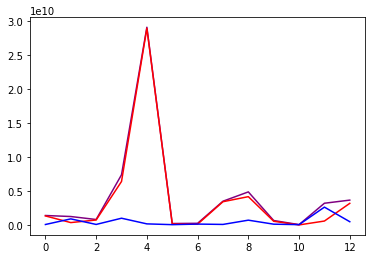

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(np.arange(0,len(combined_impact_subset.at_event)),combined_impact_subset.at_event, color="purple")
plt.plot(np.arange(0,len(tc_subset.at_event)),tc_subset.at_event, color="red")
plt.plot(np.arange(0,len(rf_subset.at_event)),rf_subset.at_event, color="blue")

In [224]:
3/(assets.gdf.value.sum()/1e10)*100

5.62983748356253

In [220]:
(all_countries_impacts[country]['1'][exposure]['RF'].aai_agg/assets.gdf.value.sum())*100

0.49786052577219475

In [221]:
(np.sum(tc_subset.at_event)/len(tc_subset.at_event)/assets.gdf.value.sum())*100

0.7204839627862102

In [222]:
(np.sum(rf_subset.at_event)/len(rf_subset.at_event)/assets.gdf.value.sum())*100

0.09192313540842074

In [11]:
# def calculate_adjusted_impact_matrix(damage_matrix, total_values, recovery_years=5, recovery_rate=0.2):
#     """
#     Calculate the adjusted impact matrix, considering the impact with dynamic recovery assumptions.

#     :param damage_matrix: Sparse matrix (years x grid points) with damage per year per grid point.
#     :param total_values: Array with the total value that can be damaged per grid point.
#     :param recovery_years: Number of years it takes for an asset to fully recover.
#     :param recovery_rate: Recovery rate per year.
#     :return: Adjusted impact matrix (years x grid points) accounting for dynamic recovery.
#     """  
#     #damage_matrix_recovery = copy.deepcopy(damage_matrix).todense()
#     damage_matrix = damage_matrix.todense()
#     damage_matrix_recovery=[]
#     for year in range(0,damage_matrix.shape[0]):
#         percentage_damage = np.asarray(damage_matrix[year,:])[0]/total_values
#         if year==0:
#             damage_matrix_recovery.append(np.array(damage_matrix[0]))
#         if year==1:
#             last_year_damage = np.array(damage_matrix[0])[0]*0.75
#             damage_matrix_recovery.append(last_year_damage+percentage_damage*(total_values-last_year_damage))
#         if year==2:
#             last_years_damage = np.array(damage_matrix[0])[0]*0.5+np.array(damage_matrix[1])[0]*0.75
                                          
#             damage_matrix_recovery.append(last_years_damage+percentage_damage*(total_values-last_years_damage))
#         if year>=3:
#             last_years_damage = np.array(damage_matrix[year-3])[0]*0.25+np.array(damage_matrix[year-2])[0]*0.5+np.array(damage_matrix[year-1])[0]*0.75
#             damage_matrix_recovery.append(last_years_damage+percentage_damage*(total_values-last_years_damage))
        
#         print(len(damage_matrix_recovery))
#     return damage_matrix_recovery

# Example usage:
# Replace 'your_sparse_matrix' with your actual 17x16092 sparse matrix
# Replace 'your_total_values_array' with your actual 16092-length array
# adjusted_impact_matrix = calculate_adjusted_impact_matrix(your_sparse_matrix, your_total_values_array)
# print("Adjusted impact matrix:", adjusted_impact_matrix)

# This script cannot be executed here as the actual data is not available.
# You can replace the placeholders with your data and run this script in your environment.


In [14]:
def calculate_adjusted_impact_single_point(impact_values, asset_value, recovery_years, consider_past_damage=False):
    annual_recovery_rate = 1.0 / recovery_years
    remaining_value = asset_value
    remaining_damage = 0
    impacts = []

    for year, impact in enumerate(impact_values, start=1):
        # Apply recovery from the previous year's damage (starting from year 2)
        if year > 1:
            recovered = remaining_damage * annual_recovery_rate
            remaining_damage -= recovered
            remaining_value += recovered

        # Calculate impact based on the remaining value
        current_impact = remaining_value * (impact / asset_value)
        
        # Apply the impact and update remaining damage
        remaining_value -= current_impact
        remaining_damage += current_impact

        # For subsequent years, add remaining damage if option is selected
        # Ensure the asset value does not go below zero or exceed the initial value
        remaining_value = min(max(remaining_value,0), asset_value)

        if consider_past_damage is False:
            impacts.append(current_impact)
        else:
            impacts.append((asset_value-remaining_value))

    return np.array(impacts)


In [15]:
import numpy as np

def calculate_adjusted_impact_matrix(damage_matrix, total_values, recovery_years=5, consider_past_damage=True):
    """
    Calculate the adjusted impact matrix, considering the impact with dynamic recovery assumptions using exponential decay.

    :param damage_matrix: Sparse matrix (years x grid points) with damage per year per grid point.
    :param total_values: Array with the total value that can be damaged per grid point.
    :param recovery_years: Number of years it takes for an asset to fully recover.
    :param consider_past_damage: Boolean flag to consider or ignore past damages in the calculation.
    :return: Adjusted impact matrix (grid points x years) accounting for dynamic recovery.
    """
    damage_matrix = damage_matrix.todense()
    damage_matrix_recovery = []

    for col in range(damage_matrix.shape[1]):
        damage_history = np.array(damage_matrix[:, col]).flatten()
        total_value = total_values[col]
        adjusted_impact = calculate_adjusted_impact_single_point(damage_history, total_value, recovery_years, consider_past_damage)
        damage_matrix_recovery.append(adjusted_impact)

    # Stack the adjusted impacts for each grid point vertically
    damage_matrix_recovery = np.vstack(damage_matrix_recovery).T

    return damage_matrix_recovery



In [16]:
damage_matrix_recovery5 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=4)
damage_matrix_recovery3 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=2)
damage_matrix_recovery1 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=1)

In [17]:
damage_matrix_recovery5_2 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=4, consider_past_damage=False)
damage_matrix_recovery3_2 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=2, consider_past_damage=False)
damage_matrix_recovery1_2 = calculate_adjusted_impact_matrix(combined_impact_subset.imp_mat, assets.gdf.value, recovery_years=1, consider_past_damage=False)

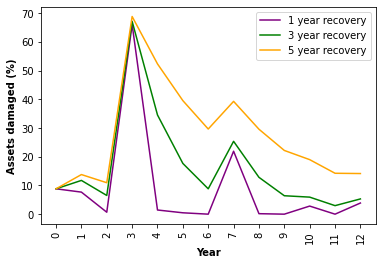

In [23]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.labelweight'] = 'bold'

n = 1# Index of the event

fig, ax = plt.subplots()

# Assuming damage_matrix_recovery and combined_impact_subset.imp_mat are numpy arrays
# Extracting data for a specific event and converting to billions
data_1 = np.array(damage_matrix_recovery1)[:, n]/assets.gdf.iloc[n].value

data_3 = np.array(damage_matrix_recovery3)[:, n]/assets.gdf.iloc[n].value

data_5 = np.array(damage_matrix_recovery5)[:, n]/assets.gdf.iloc[n].value


# Plotting the data
ax.plot(np.arange(0, len(data_1)), 100*data_1, color="Purple", label="1 year recovery")
ax.plot(np.arange(0, len(data_1)), 100*data_3, color="green", label="3 year recovery")
ax.plot(np.arange(0, len(data_1)), 100*data_5, color="orange", label="5 year recovery")

# Setting the axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Assets damaged (%)")

# Optionally, set the x-axis ticks to represent specific years
# Update this if you have a specific starting year
start_year = 0
ax.set_xticks(np.arange(0, len(data_1)))
ax.set_xticklabels([str(start_year + i) for i in range(len(data_1))], rotation=90)

# Adding a legend
ax.legend()

plt.savefig("recovery_damage_1point.pdf")

In [84]:
damage_matrix_recovery1[:, n]

array([ 14145.25460603,  12298.67676076,   1083.94900155, 105805.52365495,
         2322.63943369,    765.13607176,      0.        ,  35113.12272624,
          269.98328203,      0.        ,   4514.20877816,      0.        ,
         6217.97012952])

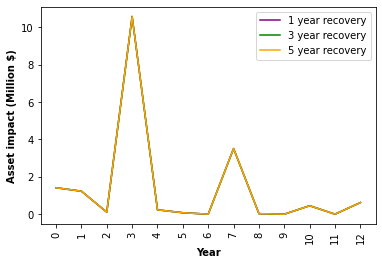

In [32]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.labelweight'] = 'bold'

n = 1  # Index of the event

fig, ax = plt.subplots()

# Assuming damage_matrix_recovery and combined_impact_subset.imp_mat are numpy arrays
# Extracting data for a specific event and converting to billions
data_1 = np.array(damage_matrix_recovery1_2)[:, n]/1e6

data_3 = np.array(damage_matrix_recovery1_2)[:, n]/1e6

data_5 = np.array(damage_matrix_recovery1_2)[:, n]/1e6


# Plotting the data
ax.plot(np.arange(0, len(data_1)), 100*data_1, color="Purple", label="1 year recovery")
ax.plot(np.arange(0, len(data_1)), 100*data_3, color="green", label="3 year recovery")
ax.plot(np.arange(0, len(data_1)), 100*data_5, color="orange", label="5 year recovery")

# Setting the axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Asset impact (Million $)")

# Optionally, set the x-axis ticks to represent specific years
# Update this if you have a specific starting year
start_year = 0
ax.set_xticks(np.arange(0, len(data_1)))
ax.set_xticklabels([str(start_year + i) for i in range(len(data_1))], rotation=90)

# Adding a legend
ax.legend()

plt.savefig("recovery_damage_1point_financial.pdf")

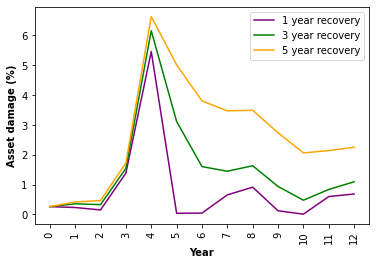

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.labelweight'] = 'bold'


fig, ax = plt.subplots()

# Assuming damage_matrix_recovery and combined_impact_subset.imp_mat are numpy arrays
# Convert the data to millions for plotting

vector_reshaped = np.array(assets.gdf.value).reshape(1, -1)
imp_1y_recovery = 100*(np.array(damage_matrix_recovery1).sum(axis=1))/(vector_reshaped.sum())
imp_3y_recovery = 100*(np.array(damage_matrix_recovery3).sum(axis=1))/(vector_reshaped.sum())
imp_5y_recovery = 100*(np.array(damage_matrix_recovery5).sum(axis=1))/(vector_reshaped.sum())



# Plotting the data
ax.plot(np.arange(0, len(data_1)), imp_1y_recovery, color="purple", label="1 year recovery")
ax.plot(np.arange(0, len(data_1)), imp_3y_recovery, color="green", label="3 year recovery")
ax.plot(np.arange(0, len(data_1)), imp_5y_recovery, color="orange", label="5 year recovery")

# Setting the axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Asset damage (%)")

# Optionally, set the x-axis ticks to represent specific years
# For example, if the first year is 2020
start_year = 0
ax.set_xticks(np.arange(0, len(data_1)))
ax.set_xticklabels([str(start_year + i) for i in range(len(data_1))], rotation=90)

# Adding a legend z

ax.legend()

plt.savefig("fig7a.pdf")

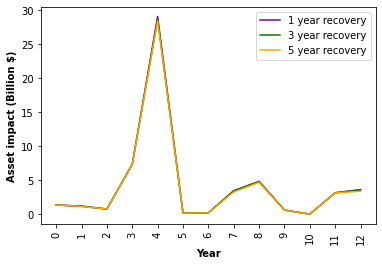

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['axes.labelweight'] = 'bold'


fig, ax = plt.subplots()

# Assuming damage_matrix_recovery and combined_impact_subset.imp_mat are numpy arrays
# Convert the data to millions for plotting

vector_reshaped = np.array(assets.gdf.value).reshape(1, -1)
imp_1y_recovery = (np.array(damage_matrix_recovery1_2).sum(axis=1))/1e9
imp_3y_recovery = (np.array(damage_matrix_recovery3_2).sum(axis=1))/1e9
imp_5y_recovery = (np.array(damage_matrix_recovery5_2).sum(axis=1))/1e9


# Plotting the data
ax.plot(np.arange(0, len(data_1)), imp_1y_recovery, color="purple", label="1 year recovery")
ax.plot(np.arange(0, len(data_1)), imp_3y_recovery, color="green", label="3 year recovery")
ax.plot(np.arange(0, len(data_1)), imp_5y_recovery, color="orange", label="5 year recovery")

# Setting the axis labels
ax.set_xlabel("Year")
ax.set_ylabel("Asset impact (Billion $)")

# Optionally, set the x-axis ticks to represent specific years
# For example, if the first year is 2020
start_year = 0
ax.set_xticks(np.arange(0, len(data_1)))
ax.set_xticklabels([str(start_year + i) for i in range(len(data_1))], rotation=90)

# Adding a legend z

ax.legend()

plt.savefig("fig7b.pdf")

In [51]:
recovery = copy.deepcopy(assets)
recovery.gdf["1y"] = np.asarray(combined_impact_subset.imp_mat.todense()).sum(axis=0)
recovery.gdf["5y"] = np.array(damage_matrix_recovery).sum(axis=0)


/scratch/tmp.37523215.szelie/ipykernel_3331/844876982.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


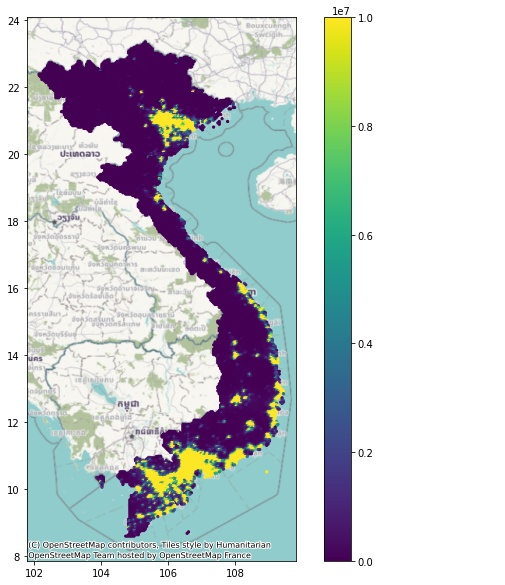

In [52]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# Example: Create a GeoDataFrame or use an existing one
# For demonstration, I'll create a simple GeoDataFrame with Points
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Create a simple plot from the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
recovery.gdf.plot("5y",ax=ax, marker='o', legend=True, markersize=5, vmax=1e7)

# Add a basemap with contextily
# The 'alpha' parameter controls the transparency of the basemap
ctx.add_basemap(ax, crs=diff_recovery.crs)
# To set a colorbar description, you'll need a plotted element with a colorbar
# Here's an example with a simple scatter plot. Replace this with your actual data plot.


plt.show()

/scratch/tmp.37523215.szelie/ipykernel_3331/2088148000.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


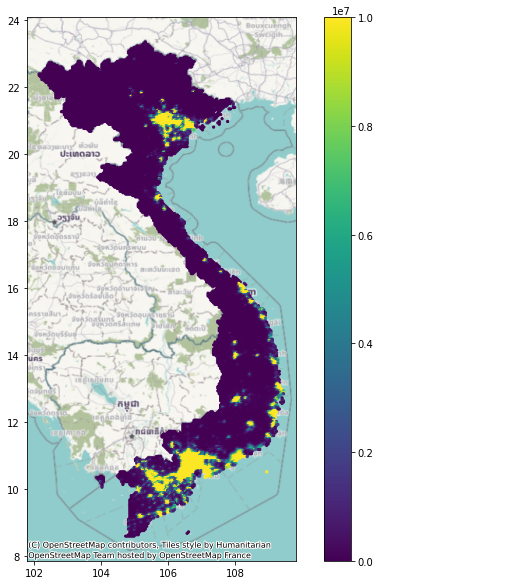

In [53]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# Example: Create a GeoDataFrame or use an existing one
# For demonstration, I'll create a simple GeoDataFrame with Points
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Create a simple plot from the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
recovery.gdf.plot("1y",ax=ax, marker='o', legend=True, markersize=5, vmax=1e7)

# Add a basemap with contextily
# The 'alpha' parameter controls the transparency of the basemap
ctx.add_basemap(ax, crs=diff_recovery.crs)
# To set a colorbar description, you'll need a plotted element with a colorbar
# Here's an example with a simple scatter plot. Replace this with your actual data plot.


plt.show()


In [56]:
recovery

/scratch/tmp.37523215.szelie/ipykernel_3331/893550256.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))


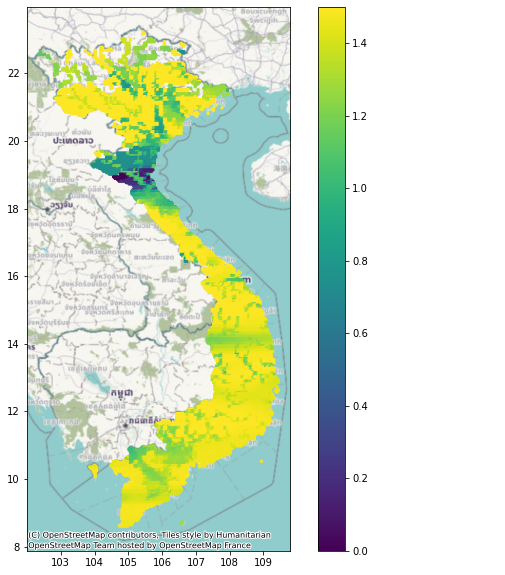

In [63]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# Example: Create a GeoDataFrame or use an existing one
# For demonstration, I'll create a simple GeoDataFrame with Points
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

# Create a simple plot from the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
recovery.gdf['rel_diff'] = (recovery.gdf['5y'] - recovery.gdf['1y'])/recovery.gdf['1y']
recovery.gdf.plot("rel_diff",ax=ax, marker='o', legend=True, markersize=5)

# Add a basemap with contextily
# The 'alpha' parameter controls the transparency of the basemap
ctx.add_basemap(ax, crs=diff_recovery.crs)
# To set a colorbar description, you'll need a plotted element with a colorbar
# Here's an example with a simple scatter plot. Replace this with your actual data plot.


plt.show()
